In [63]:
"""
Configuration for WoSIS (World Soil Information Service) data visualization

This configuration file contains parameters for loading, filtering and visualizing soil data.
All paths are relative to the notebook location.
"""

# Input data configuration
datasets = [
    "../outputs/Mexico_wosis_merged.csv",  # Path to the main dataset file
]  # Additional datasets can be appended to this list if needed

dataset_title = "Mexico"  # Title used for plots and outputs
target_column = "orgc_value"  # Main variable of interest for analysis
threshold_of_missing_values = 0.3  # Maximum allowed proportion (30%) of missing values
map_file = "../data/mexico.geojson"  # GeoJSON file containing Mexico's boundaries

# Column name mappings
# These columns are used to calculate derived soil properties
orgc_column_name = "orgc_value"  # Organic carbon content
silt_column_name = "silt_value"  # Silt content percentage 
clay_column_name = "clay_value"  # Clay content percentage

# Temporal analysis configuration
temporal_column_name = "date"  # Column containing timestamp information
temporal_feature_columns = [
    "orgc_value",
    "silt_value", 
    "clay_value"
]  # Soil properties to analyze over time

# Temporal and spatial bounds
temporal_bounding_years = [2005]  # Years to use as cutoff points in temporal analysis
temporal_bounding_coordinates = [
    -117.12,  # Western longitude
    14.53,    # Southern latitude
    -86.81,   # Eastern longitude
    32.72     # Northern latitude
]  # Geographic bounds for filtering data points

# ---- do not modify below this line, unless you know what you are doing ----

#### Combine the datasets

In [64]:
from typing import Optional, List, Tuple, Dict
import logging
import pandas as pd
import os

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def validate_config(
    datasets: List[str],
    dataset_title: str,
    target_column: str,
    threshold_of_missing_values: float,
    map_file: str,
    orgc_column_name: str,
    silt_column_name: str,
    clay_column_name: str,
) -> None:
    """
    Validate configuration parameters.
    
    Args:
        datasets: List of dataset paths to load
        dataset_title: Title of the dataset
        target_column: Column to analyze
        threshold_of_missing_values: Maximum allowed proportion of missing values
        map_file: Path to map file
        orgc_column_name: Name of organic carbon column
        silt_column_name: Name of silt column
        clay_column_name: Name of clay column
    
    Raises:
        ValueError: If any required parameters are invalid
        FileNotFoundError: If dataset files don't exist
    """
    # Validate required parameters
    if not all([datasets, dataset_title, target_column, map_file, 
                orgc_column_name, silt_column_name, clay_column_name]):
        raise ValueError("All configuration parameters must be provided")

    # Validate threshold
    if not 0 <= threshold_of_missing_values <= 1:
        raise ValueError("Threshold of missing values must be between 0 and 1")

    # Check input files exist
    for dataset in datasets:
        if not os.path.exists(dataset):
            raise FileNotFoundError(f"Dataset file not found: {dataset}")
            
    if not os.path.exists(map_file):
        raise FileNotFoundError(f"Map file not found: {map_file}")

validate_config(datasets, dataset_title, target_column, threshold_of_missing_values, map_file, orgc_column_name, silt_column_name, clay_column_name)

# load data
load_data = []
for dataset in datasets:
    df = pd.read_csv(dataset)
    load_data.append(df)

# append dataframes
master_dataset = pd.concat(load_data, ignore_index=True)

# visualize data as table
master_dataset.head()

date   longitude   latitude  upper_depth  lower_depth country_name  \
0  1900-01-01 -117.067005  32.381501            0           17       Mexico   
1  1900-01-01 -116.919581  32.337061            0           15       Mexico   
2  1900-01-01 -116.879896  32.447350            0           13       Mexico   
3  1900-01-01 -116.875039  32.374552            0           28       Mexico   
4  1900-01-01 -116.866757  32.170764            0           16       Mexico   

            region         continent  bdfiod_value  bdwsod_value  ...  \
0  Central America  Northern America           NaN           NaN  ...   
1  Central America  Northern America           NaN           NaN  ...   
2  Central America  Northern America           NaN           NaN  ...   
3  Central America  Northern America           NaN           NaN  ...   
4  Central America  Northern America           NaN           NaN  ...   

   cfvo_value  clay_value  ecec_value  nitkjd_value  orgc_value  phaq_value  \
0         NaN        48.0         NaN           NaN         NaN         8.2   
1         NaN        18.0         NaN           NaN         NaN         6.1   
2         NaN        24.0         NaN           NaN         NaN         8.2   
3         NaN        36.0         NaN           NaN         NaN         7.6   
4         NaN        40.0         NaN           NaN         NaN         6.4   

   sand_value  silt_value  tceq_value  totc_value  
0        36.0        16.0         NaN         NaN  
1        32.0        50.0         NaN         NaN  
2        58.0        18.0         NaN         NaN  
3        30.0        30.0         NaN         NaN  
4        36.0        24.0         NaN         NaN  

[5 rows x 21 columns]

#### Visualise the missing values in the dataset

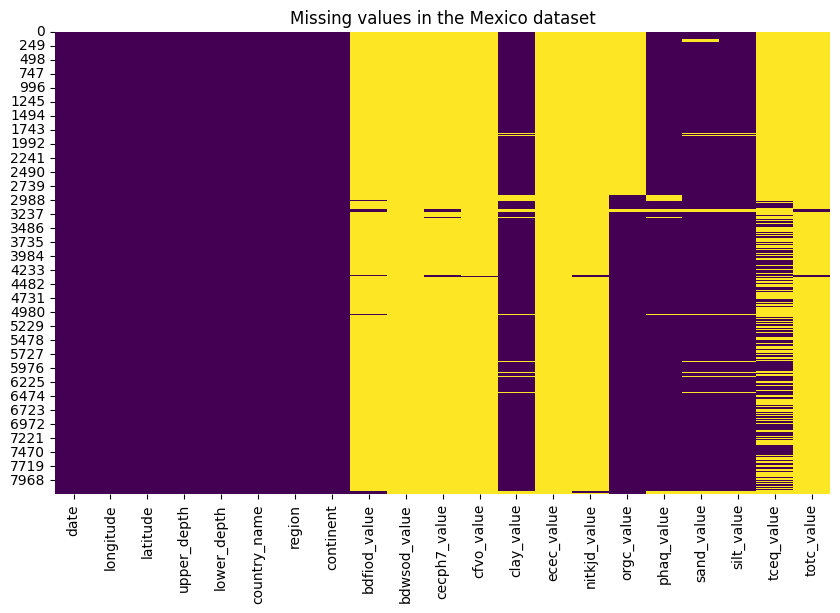

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot missing values
plt.figure(figsize=(10, 6))
sns.heatmap(master_dataset.isnull(), cbar=False, cmap='viridis')
plt.title(f'Missing values in the {dataset_title} dataset')
plt.show()

#### Visualise the data distribution

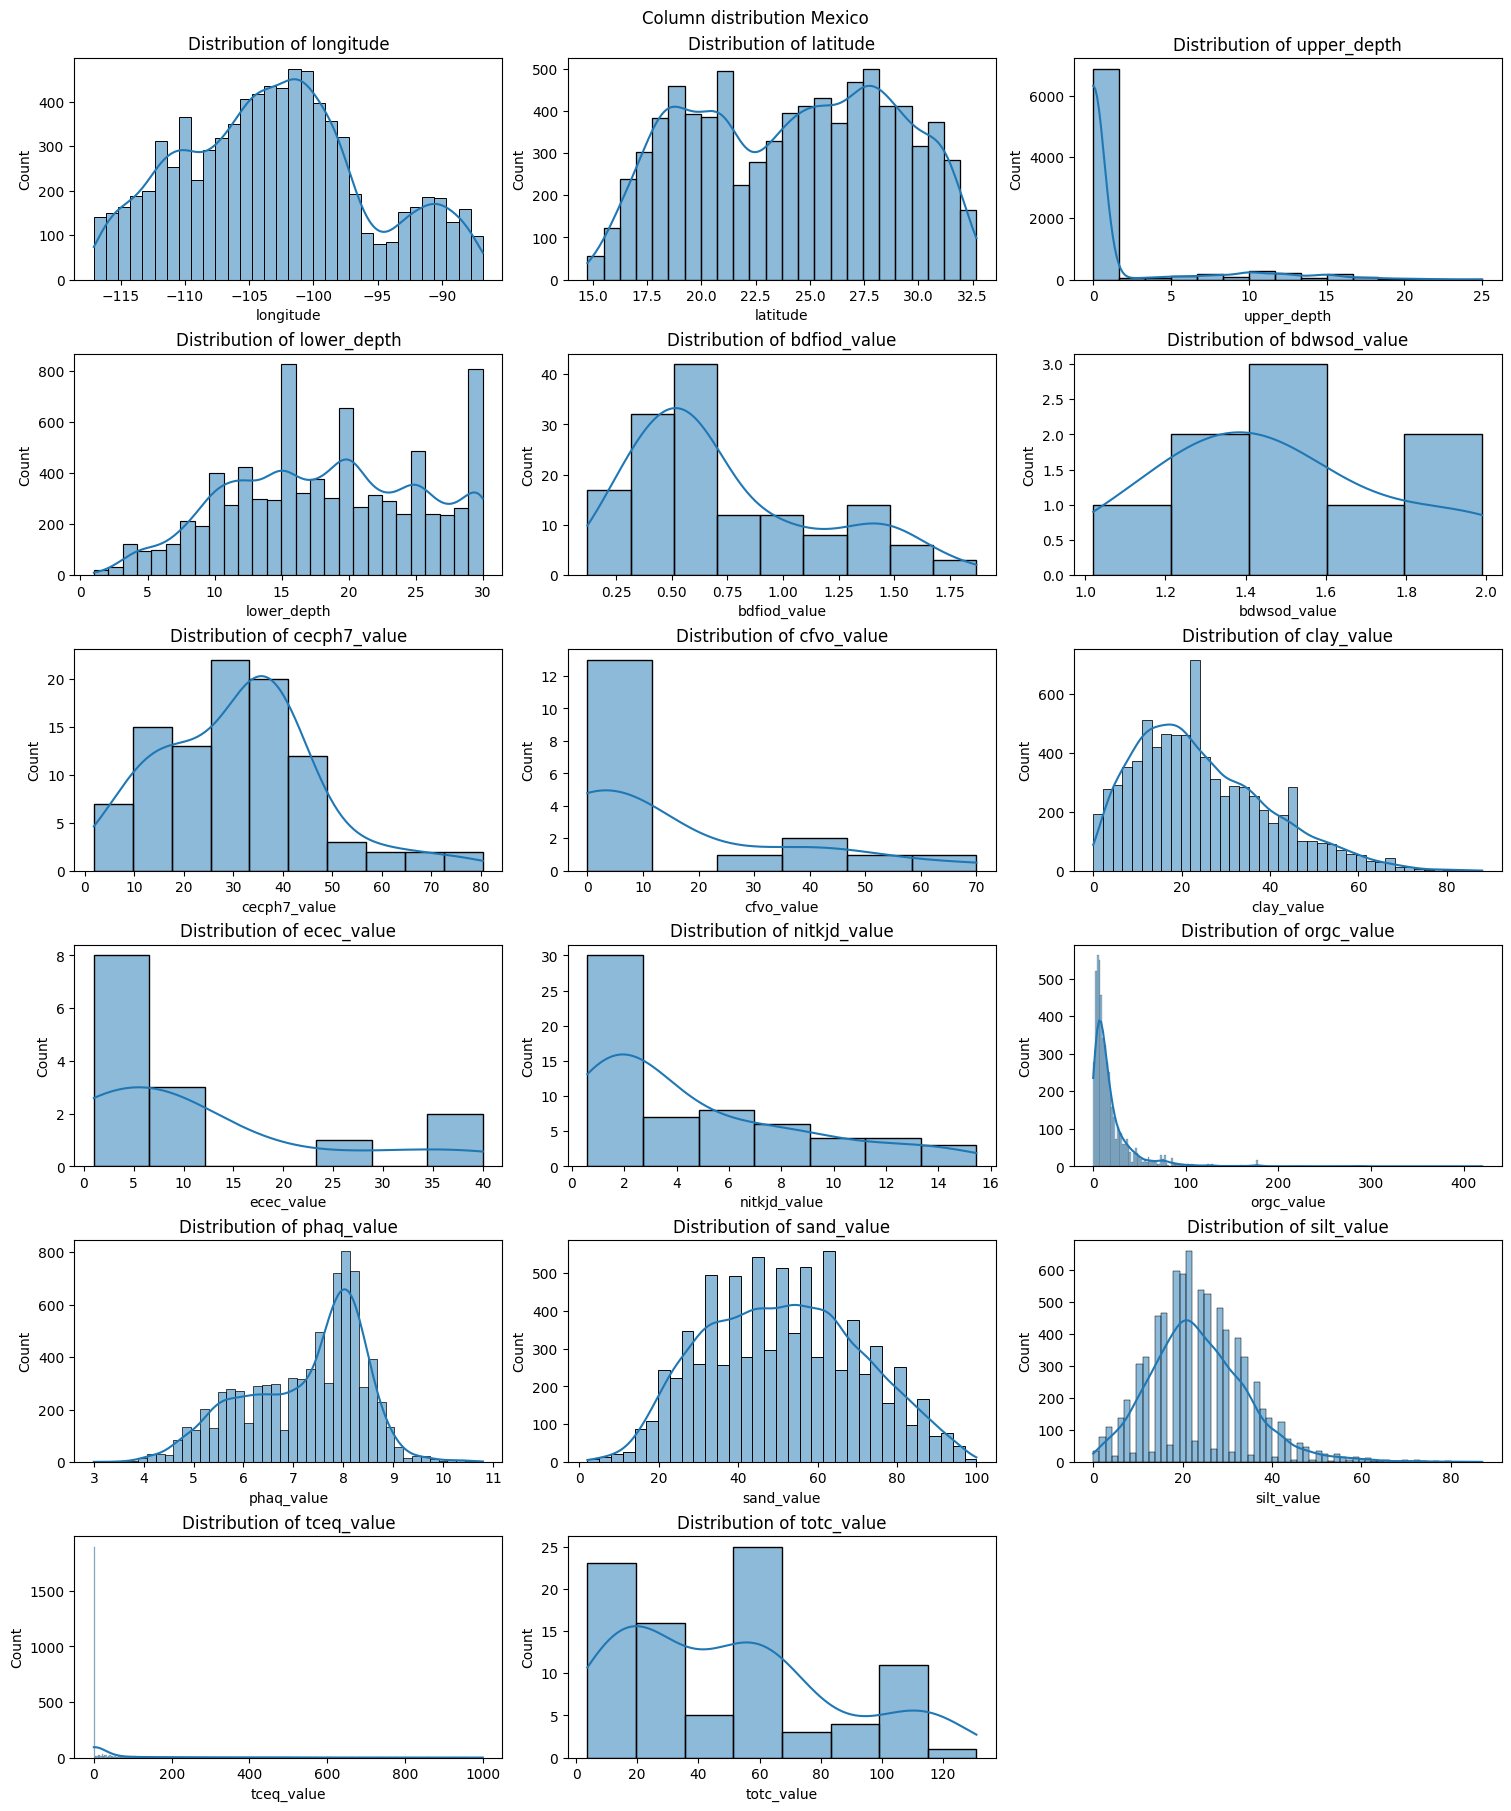

In [66]:
# Visualising data distribution
import math
def plot_distribution_charts(numeric_columns, dataset, title=""):
    num_cols = len(numeric_columns)

    # Define the number of rows and columns dynamically
    chart_cols = 3  # Fixed number of columns
    chart_rows = math.ceil(num_cols / chart_cols)  # Calculate required rows based on columns

    fig, axes = plt.subplots(chart_rows, chart_cols, figsize=(15, 3 * chart_rows), constrained_layout=True)
    axes = axes.flatten()  # Flatten the axes for easy iteration

    for i, col in enumerate(numeric_columns):
        sns.histplot(dataset[col], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f"Column distribution {title}")
    plt.show()


# plot distribution charts
numeric_columns_dataset = master_dataset.select_dtypes(include=['float64', 'int64']).columns
plot_distribution_charts(numeric_columns_dataset, master_dataset, dataset_title)

#### Adding new columns

In [67]:
# create organic matter
master_dataset['organic_matter'] = master_dataset.apply(lambda row: 1.724 * row[orgc_column_name], axis=1)

# create bulk density
master_dataset[f'bulk_density'] = master_dataset.apply(lambda row: 1.62-0.06 * row['organic_matter'], axis=1)

# create sum of silt plus clay
master_dataset[f'silt_plus_clay'] = master_dataset.apply(lambda row: (row[silt_column_name] if not pd.isnull(row[silt_column_name]) else 0) + (row[clay_column_name] if not pd.isnull(row[clay_column_name]) else 0) , axis=1)

# drop silt and clay column
# master_dataset = master_dataset.drop(columns=[silt_column_name, clay_column_name]).copy()

print(f"\n Length of dataset: {len(master_dataset)}")


 Length of dataset: 8207


## Temporal Visualization


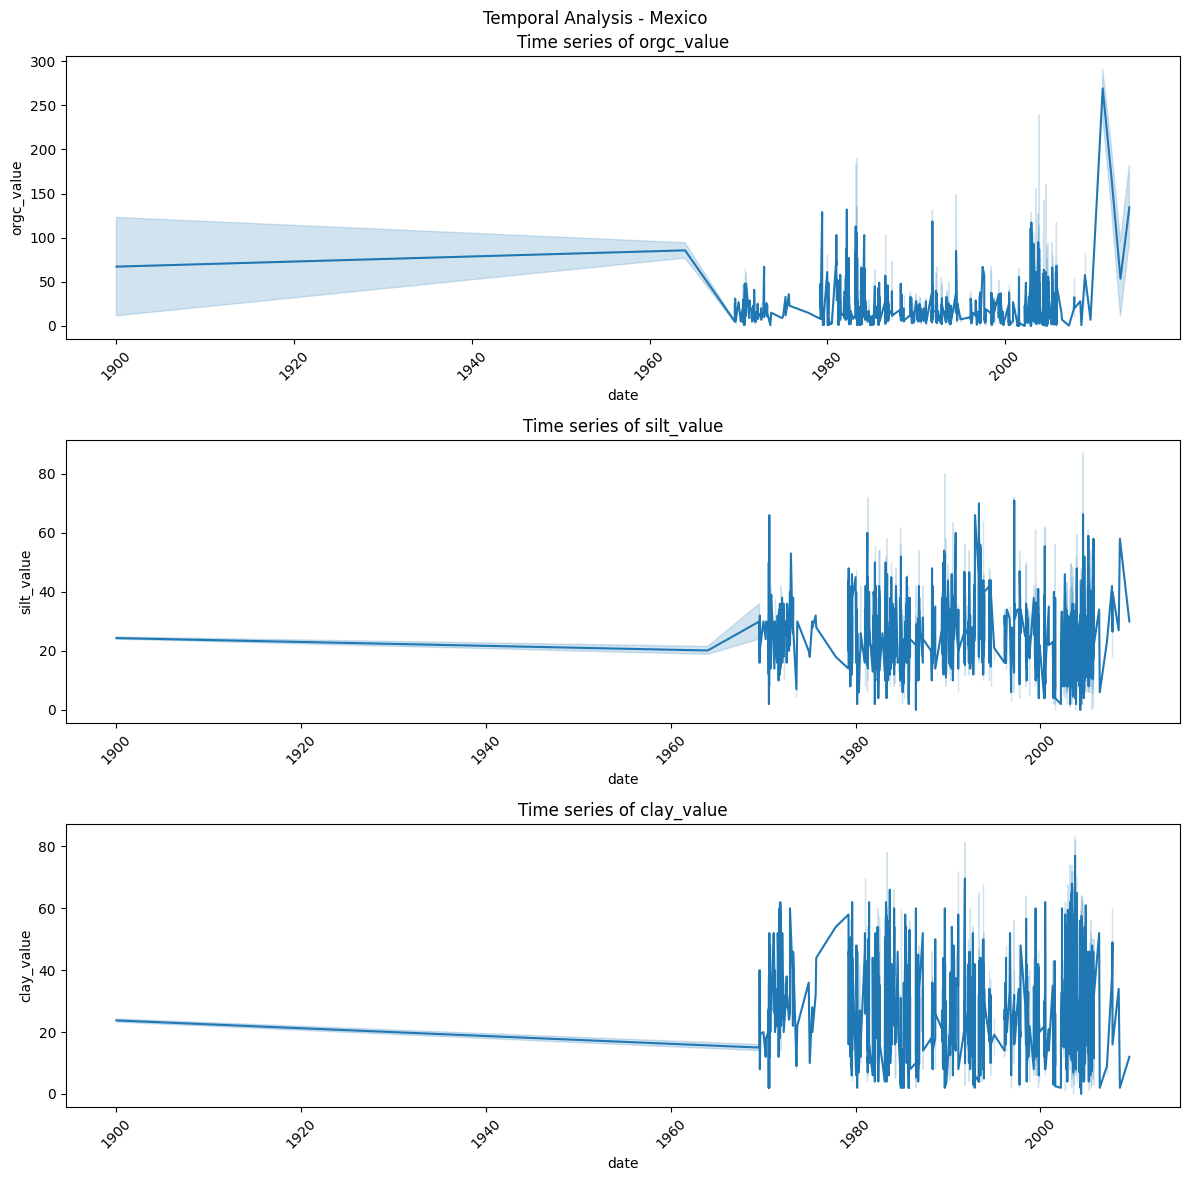

In [68]:
def plot_temporal_features(temporal_column, feature_columns, dataset, title, temporal_bounding_years=None, temporal_bounding_coordinates=None):
    """Plot multiple time series in a single figure with subplots
    
    Args:
        temporal_column (str): Name of the column containing temporal data
        feature_columns (list): List of column names to plot
        dataset (pd.DataFrame): Input dataset
        title (str): Title for the plot
        temporal_bounding_years (list): List of bounding years for temporal visualization
        temporal_bounding_coordinates (list): List of bounding coordinates for temporal visualization
    """
    # Convert temporal column to datetime if it's string
    dataset = dataset.copy()
    dataset[temporal_column] = pd.to_datetime(dataset[temporal_column])
    
    n_features = len(feature_columns)
    fig, axes = plt.subplots(n_features, 1, figsize=(12, 4*n_features))
    if n_features == 1:
        axes = [axes]
        
    for ax, feature in zip(axes, feature_columns):
        # Convert feature values to numeric if they're strings
        if dataset[feature].dtype == 'object':
            dataset[feature] = pd.to_numeric(dataset[feature], errors='coerce')
            
        """  
        # Filter by year range
        if temporal_bounding_years:
            mask = (dataset[temporal_column].dt.year >= temporal_bounding_years[0]) & \
                   (dataset[temporal_column].dt.year <= temporal_bounding_years[1])
            dataset = dataset[mask]
            
        # Filter by bounding coordinates
        if temporal_bounding_coordinates:
            mask = (dataset['latitude'] >= temporal_bounding_coordinates[1]) & \
                   (dataset['latitude'] <= temporal_bounding_coordinates[3]) & \
                   (dataset['longitude'] >= temporal_bounding_coordinates[0]) & \
                   (dataset['longitude'] <= temporal_bounding_coordinates[2])
            dataset = dataset[mask] 
        """
            

        sns.lineplot(data=dataset, x=temporal_column, y=feature, ax=ax)
        ax.set_title(f'Time series of {feature}')
        ax.tick_params(axis='x', rotation=45)
    
    plt.suptitle(f'Temporal Analysis - {title}')
    plt.tight_layout()
    plt.show()

# Create single plot with all features
plot_temporal_features(temporal_column_name, temporal_feature_columns, master_dataset, dataset_title, temporal_bounding_years, temporal_bounding_coordinates)

## Standardise the data

In [69]:
from sklearn.preprocessing import StandardScaler

dataset = master_dataset.copy()
# remove missing columns with threshold
dataset = dataset.dropna(thresh=threshold_of_missing_values * len(dataset), axis=1)
# fill missing values with mean
numeric_columns_dataset = dataset.select_dtypes(include=['float64', 'int64']).columns[~dataset.select_dtypes(include=['float64', 'int64']).columns.isin(['geometry', 'latitude', 'longitude'])]
dataset[numeric_columns_dataset] = dataset[numeric_columns_dataset].apply(lambda x: x.fillna(x.mean()), axis=0)

# Normalise the data
scaler = StandardScaler()
dataset_scaled = scaler.fit_transform(dataset[numeric_columns_dataset])
standard_dataset = pd.DataFrame(dataset_scaled, columns=dataset[numeric_columns_dataset].columns)

# add lat and long columns
standard_dataset['latitude'] = dataset['latitude']
standard_dataset['longitude'] = dataset['longitude']

standard_dataset.head()

upper_depth  lower_depth  clay_value  orgc_value  phaq_value  sand_value  \
0    -0.401782    -0.196010    1.585998         0.0    0.829144   -0.810634   
1    -0.401782    -0.478479   -0.443899         0.0   -0.963636   -1.020828   
2    -0.401782    -0.760947   -0.037920         0.0    0.829144    0.345428   
3    -0.401782     1.357565    0.774039         0.0    0.316921   -1.125924   
4    -0.401782    -0.337245    1.044692         0.0   -0.707525   -0.810634   

   silt_value    tceq_value  organic_matter  bulk_density  silt_plus_clay  \
0   -0.704108 -8.850979e-17             0.0 -2.335617e-17        0.843929   
1    2.429435 -8.850979e-17             0.0 -2.335617e-17        1.037347   
2   -0.519782 -8.850979e-17             0.0 -2.335617e-17       -0.219871   
3    0.586174 -8.850979e-17             0.0 -2.335617e-17        0.940638   
4    0.033196 -8.850979e-17             0.0 -2.335617e-17        0.843929   

    latitude   longitude  
0  32.381501 -117.067005  
1  32.337061 -116.919581  
2  32.447350 -116.879896  
3  32.374552 -116.875039  
4  32.170764 -116.866757

## Spatial Visualization

#### Eploratory Spatial Analysis


In [70]:
# Global Morans I
import geopandas as gpd
from libpysal.weights import KNN
from esda.moran import Moran, Moran_Local

gdf = gpd.GeoDataFrame(standard_dataset, crs="EPSG:4326", geometry=gpd.points_from_xy(standard_dataset.longitude, standard_dataset.latitude))

# Use KNN weights instead of Queen since we have point data
weights = KNN.from_dataframe(gdf, k=8)

moran = Moran(gdf[target_column], weights)

print(f"Global Morans I for {target_column}: {moran.I}")
print(f"Global Morans I p-value for {target_column}: {moran.p_sim}")

# Local Moran's I
# Calculate Local Moran's I
local_moran = Moran_Local(gdf[target_column], weights)

print(f"Local Moran's I for {target_column}: {local_moran.Is}")
print(f"Local Moran's I p-value for {target_column}: {local_moran.p_sim}")

# Add results to GeoDataFrame
gdf['local_I'] = local_moran.Is
gdf['significance'] = local_moran.p_sim

# Hotspot/Coldspot classification
gdf['cluster'] = local_moran.q

d:\miniconda3\envs\tf\lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


Global Morans I for orgc_value: 0.49042299966636865
Global Morans I p-value for orgc_value: 0.001
Local Moran's I for orgc_value: [9.79181421e-19 1.61928039e-18 2.38353500e-19 ... 2.17673301e+01
 5.49421375e+01 5.51505539e+01]
Local Moran's I p-value for orgc_value: [0.406 0.215 0.426 ... 0.001 0.001 0.001]


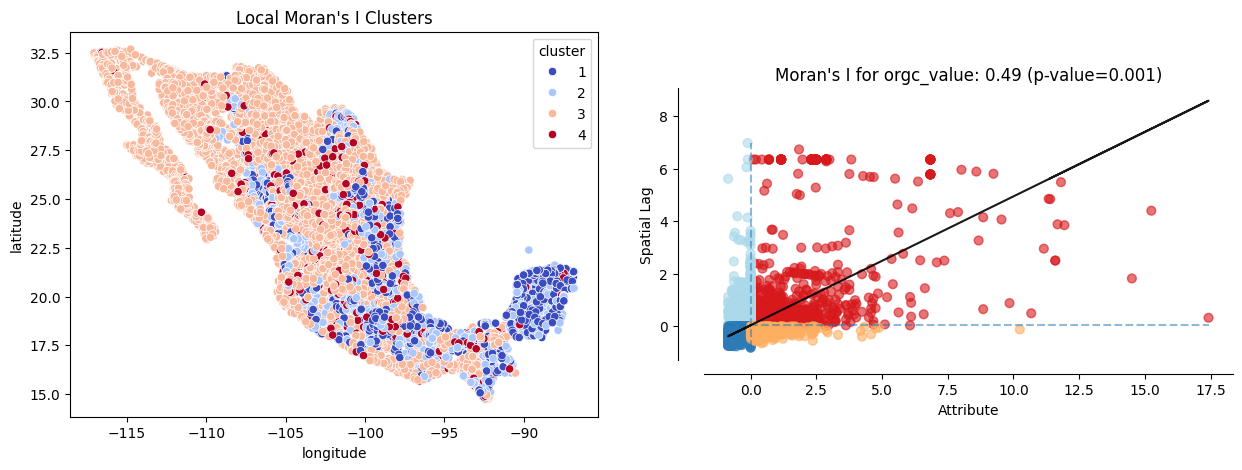

In [71]:
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot

# Plot clusters
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(data=gdf, x='longitude', y='latitude', hue='cluster', ax=ax[0], palette='coolwarm')
ax[0].set_title('Local Moran\'s I Clusters')

moran_scatterplot(local_moran, gdf[target_column], p=True, aspect_equal=True, ax=ax[1])
ax[1].set_title(f'Moran\'s I for {target_column}: {moran.I:.2f} (p-value={moran.p_sim})')

plt.show()


In [74]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# Convert to a DataFrame
df = pd.DataFrame(gdf)

# Find the centroid for initializing the map
centroid_lat = df['latitude'].mean()
centroid_lon = df['longitude'].mean()

print('Coordinates: ', centroid_lat, centroid_lon)
print('Target column: ', target_column)

# Initialize a Folium map
map = folium.Map(location=[centroid_lat, centroid_lon], zoom_start=5)

# Prepare data for the HeatMap plugin
heat_data = [[row['latitude'], row['longitude'], row[target_column]] for index, row in df.iterrows()]

# Add the HeatMap layer
HeatMap(heat_data, radius=15, blur=10, max_zoom=1).add_to(map)

map

Coordinates:  24.2149479272006 -103.02584935904937
Target column:  orgc_value


####  Hotspot/Coldspot Analysis

In [75]:
# Separate hot spots (High-High), cold spots (Low-Low), and non-significant
hotspots = gdf[(gdf['cluster'] == 1) & gdf['significance']]
coldspots = gdf[(gdf['cluster'] == 3) & gdf['significance']]

map = folium.Map(location=[gdf.geometry.y.mean(), gdf.geometry.x.mean()], zoom_start=10)

# Add hotspots
for idx, row in hotspots.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        tooltip="Hotspot"
    ).add_to(map)

# Add cold spots
for idx, row in coldspots.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        tooltip="Coldspot"
    ).add_to(map)

map